In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = [15, 5]

In [2]:
%load_ext autoreload
%autoreload 2
%run '../main.py'

In [3]:
dataSetOps = DataSetOps()

dataSetOps.import_years(2017, 2017)

dataSetOps.prepare()


df = dataSetOps.df

In [4]:
# variables
mavgl = 50
window = 15
epilson = 0.0002

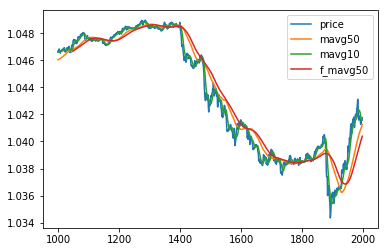

In [5]:
mavgl = str(mavgl)
df['f_mavg' + mavgl] = df['mavg' + mavgl].shift(-window).rolling(window=50).mean()
df['f_price'] = df['price'].shift(-window).rolling(window=window).max()
df['value'] = df['f_mavg' + mavgl] - df['mavg' + mavgl] > epilson
df['value_real'] = df['f_price'] - df['price'] > epilson
df[['price', 'mavg' + mavgl, 'mavg10', 'f_mavg' + mavgl]].head(1000).plot()

0.07781240303802933


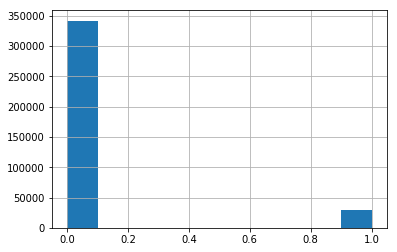

In [6]:
df['value'].astype(int).hist()
print(len(df[df['value']]) / (len(df)))

In [7]:
X = df[['price', 'mavg10', 'mavg20', 'mavg50', 'mavg80', 'mavg100', 'mavg1000']]
Y = df['value']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [8]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense

    
#Initializing Neural Network
classifier = Sequential()

class1 = Dense(output_dim = 16, init = 'uniform', activation = 'relu', input_dim = 7)
class2 = Dense(output_dim = 16, init = 'uniform', activation = 'relu')
class3 = Dense(output_dim = 16, init = 'uniform', activation = 'relu')
# Adding the input layer and the first hidden layer
classifier.add(class1)
# Adding the second hidden layer
classifier.add(class2)
classifier.add(class3)
# Adding the output layer
classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

# Compiling Neural Network
from keras import metrics
metric_names = [metrics.mae, 'accuracy']
classifier.compile(optimizer='adam', loss = 'mean_squared_error', metrics=metric_names)


# Fitting our model 
classifier.fit(X_train, y_train, batch_size = 20, epochs = 7)
import random
classifier.save("/tmp/mavg_classifier_" + str(random.randint(100000, 999999)))

Using TensorFlow backend.
/home/taleh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=7, units=16, kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
/home/taleh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=16, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()
/home/taleh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=16, kernel_initializer="uniform")`
  if sys.path[0] == '':
/home/taleh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`


Epoch 1/7
333571/333571 [==============================] - 8s 23us/step - loss: 0.0701 - mean_absolute_error: 0.1410 - acc: 0.9225
Epoch 2/7
333571/333571 [==============================] - 7s 22us/step - loss: 0.0584 - mean_absolute_error: 0.1148 - acc: 0.9278
Epoch 3/7
333571/333571 [==============================] - 7s 22us/step - loss: 0.0476 - mean_absolute_error: 0.0949 - acc: 0.9390
Epoch 4/7
333571/333571 [==============================] - 7s 22us/step - loss: 0.0439 - mean_absolute_error: 0.0873 - acc: 0.9432
Epoch 5/7
333571/333571 [==============================] - 7s 22us/step - loss: 0.0417 - mean_absolute_error: 0.0828 - acc: 0.9457
Epoch 6/7
333571/333571 [==============================] - 7s 22us/step - loss: 0.0413 - mean_absolute_error: 0.0812 - acc: 0.9465
Epoch 7/7
333571/333571 [==============================] - 7s 22us/step - loss: 0.0395 - mean_absolute_error: 0.0786 - acc: 0.9482


In [9]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
from lib.helper import AccuracyCalculator

# Predicting the Test set results
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, (y_pred > 0.8))

AccuracyCalculator.class_accuracy(cm)
AccuracyCalculator.optimistic_accuracy(y_pred[:,0], y_test, 100)
risk_hist_df = AccuracyCalculator.risk_hist(y_pred[:,0], y_test)


class_accuracy => accuracy:  0.6136781765793385 risk:  0.07412587412587412
optimistic_accuracy => risk:  0.09 min pass point:  0.89104


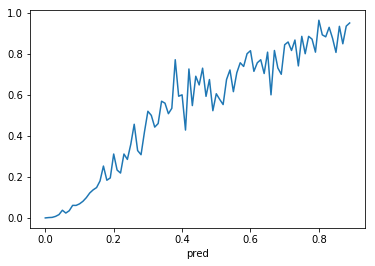

In [10]:
(1-risk_hist_df.risk).plot()

In [11]:
cm

array([[34119,    53],
       [ 2230,   662]])

In [12]:
dfx = df[df['value']]
p_f = len(dfx[dfx['value_real']]) / len(dfx)
p_r = cm[1,1] / (cm[1,1] + cm[0,1])
print('real prob', p_f , p_r, p_f * p_r)

real prob 0.6476768377253814 0.9258741258741259 0.5996672259779056


class_accuracy => accuracy:  0.5174033839798756 risk:  0.34172246594320016
optimistic_accuracy => risk:  0.19 min pass point:  0.89104
[[189528   5920]
 [163783  11404]]


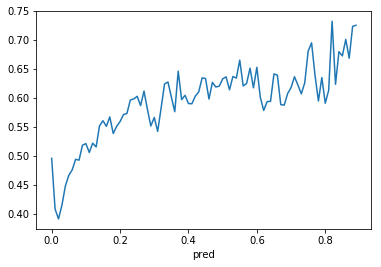

In [13]:
y_all_pred = classifier.predict(sc.transform(X))
y_f_price_real = df['value_real']
cm = confusion_matrix(y_f_price_real, (y_all_pred > 0.5))

AccuracyCalculator.class_accuracy(cm)
AccuracyCalculator.optimistic_accuracy(y_all_pred[:,0], y_f_price_real, 100)
risk_hist_df = AccuracyCalculator.risk_hist(y_all_pred[:,0], y_f_price_real)

print(cm)

(1-risk_hist_df.risk).plot()



0.6476768377253814
28840


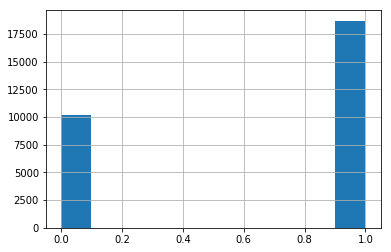

In [14]:
dfr = df[df['value']]
dfr['value_real'].astype(int).hist()
print(len(dfr[dfr['value_real']]) / (len(dfr)))
print(len(dfr['value_real']))